In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Key variables for illiquid stock analysis
FRED = "FEDFUNDS"
ILLIQUID_TICKER = "KELYB"
LIQUID_INDEX_TICKER = "SPY"
VOLATILITY_TRACKER = "^VIX"

## CODE from M1 Lesson 1 of FD
def get_fred_data(param_list, start_date, end_date) -> pd.DataFrame:
    df = pdr.DataReader(param_list, "fred", start_date, end_date) 
    return df.reset_index()

In [3]:
PERIOD_START = "2017-01-01"
PERIOD_END = "2024-01-01"

In [4]:
def extract_and_process_stocks() -> pd.DataFrame:

    stock = yf.Ticker(ILLIQUID_TICKER)
    stock_df = stock.history(start=PERIOD_START, end=PERIOD_END).reset_index()
    stock_df['Date'] = stock_df['Date'].dt.tz_localize(None)

    index = yf.Ticker(LIQUID_INDEX_TICKER)
    index_df = index.history(start=PERIOD_START, end=PERIOD_END).reset_index()
    index_df['Date'] = index_df['Date'].dt.tz_localize(None)
    index_df.head()

    vol_tracker = yf.Ticker(VOLATILITY_TRACKER)
    vol_df = vol_tracker.history(start=PERIOD_START, end=PERIOD_END).reset_index()
    vol_df = vol_df.rename(columns={col:f'{col}_{VOLATILITY_TRACKER}' for col in vol_df.columns.drop("Date")})
    vol_df['Date'] = vol_df['Date'].dt.tz_localize(None)
    vol_df.head()

    fed_rate = get_fred_data(param_list=[FRED], start_date=PERIOD_START, end_date=PERIOD_END)
    fed_rate_df = pd.DataFrame(columns=['Date'])
    fed_rate_df['Date'] = pd.date_range(PERIOD_START, PERIOD_END, freq='D')
    fed_rate_df = pd.merge(fed_rate_df, fed_rate, how='left', left_on='Date', right_on='DATE').drop(columns=['DATE']).ffill()
    fed_rate_df['FEDFUNDS'] = fed_rate_df['FEDFUNDS'].apply(np.floor)

    return pd.merge(pd.merge(pd.merge(stock_df, index_df, how='inner', on='Date', suffixes=[f"_{ILLIQUID_TICKER}", f"_{LIQUID_INDEX_TICKER}"]), fed_rate_df, on="Date"), vol_df, on="Date")

In [5]:
final_df = extract_and_process_stocks()
final_df.tail(10)

,Date,Open_KELYB,High_KELYB,Low_KELYB,Close_KELYB,Volume_KELYB,Dividends_KELYB,Stock Splits_KELYB,Open_SPY,High_SPY,...,Stock Splits_SPY,Capital Gains,FEDFUNDS,Open_^VIX,High_^VIX,Low_^VIX,Close_^VIX,Volume_^VIX,Dividends_^VIX,Stock Splits_^VIX
1750,2023-12-15,20.90,20.90,20.90,20.90,100,0.0,0.0,469.489990,470.700012,...,0.0,0.0,5.0,12.12,12.54,12.01,12.28,0,0.0,0.0
1751,2023-12-18,20.90,20.90,20.90,20.90,0,0.0,0.0,470.980011,472.980011,...,0.0,0.0,5.0,12.62,12.64,12.40,12.56,0,0.0,0.0
1752,2023-12-19,20.90,20.90,20.90,20.90,0,0.0,0.0,472.529999,474.920013,...,0.0,0.0,5.0,12.60,12.60,12.33,12.53,0,0.0,0.0
1753,2023-12-20,20.90,20.90,20.90,20.90,0,0.0,0.0,473.959991,475.899994,...,0.0,0.0,5.0,12.63,13.93,12.29,13.67,0,0.0,0.0
1754,2023-12-21,21.15,21.15,21.15,21.15,100,0.0,0.0,471.329987,472.980011,...,0.0,0.0,5.0,13.40,14.49,13.34,13.65,0,0.0,0.0
1755,2023-12-22,21.65,21.65,21.65,21.65,200,0.0,0.0,473.859985,475.380005,...,0.0,0.0,5.0,13.72,13.96,13.00,13.03,0,0.0,0.0
1756,2023-12-26,21.65,21.65,21.65,21.65,0,0.0,0.0,474.070007,476.579987,...,0.0,0.0,5.0,13.77,13.80,12.96,12.99,0,0.0,0.0
1757,2023-12-27,21.65,21.65,21.65,21.65,0,0.0,0.0,475.440002,476.660004,...,0.0,0.0,5.0,13.02,13.04,12.37,12.43,0,0.0,0.0
1758,2023-12-28,21.65,21.65,21.65,21.65,0,0.0,0.0,476.880005,477.549988,...,0.0,0.0,5.0,12.44,12.65,12.38,12.47,0,0.0,0.0
1759,2023-12-29,21.65,21.65,21.65,21.65,0,0.0,0.0,476.489990,477.029999,...,0.0,0.0,5.0,12.55,13.19,12.36,12.45,0,0.0,0.0


In [6]:
final_df[f'Log Returns {LIQUID_INDEX_TICKER}'] = np.log10(final_df[f'Close_{LIQUID_INDEX_TICKER}']/final_df[f'Close_{LIQUID_INDEX_TICKER}'].shift(1))
final_df[f'Log Returns {ILLIQUID_TICKER}'] = np.log10(final_df[f'Close_{ILLIQUID_TICKER}']/final_df[f'Close_{ILLIQUID_TICKER}'].shift(1))

Text(0.5, 0.98, 'Log Returns Time Series')

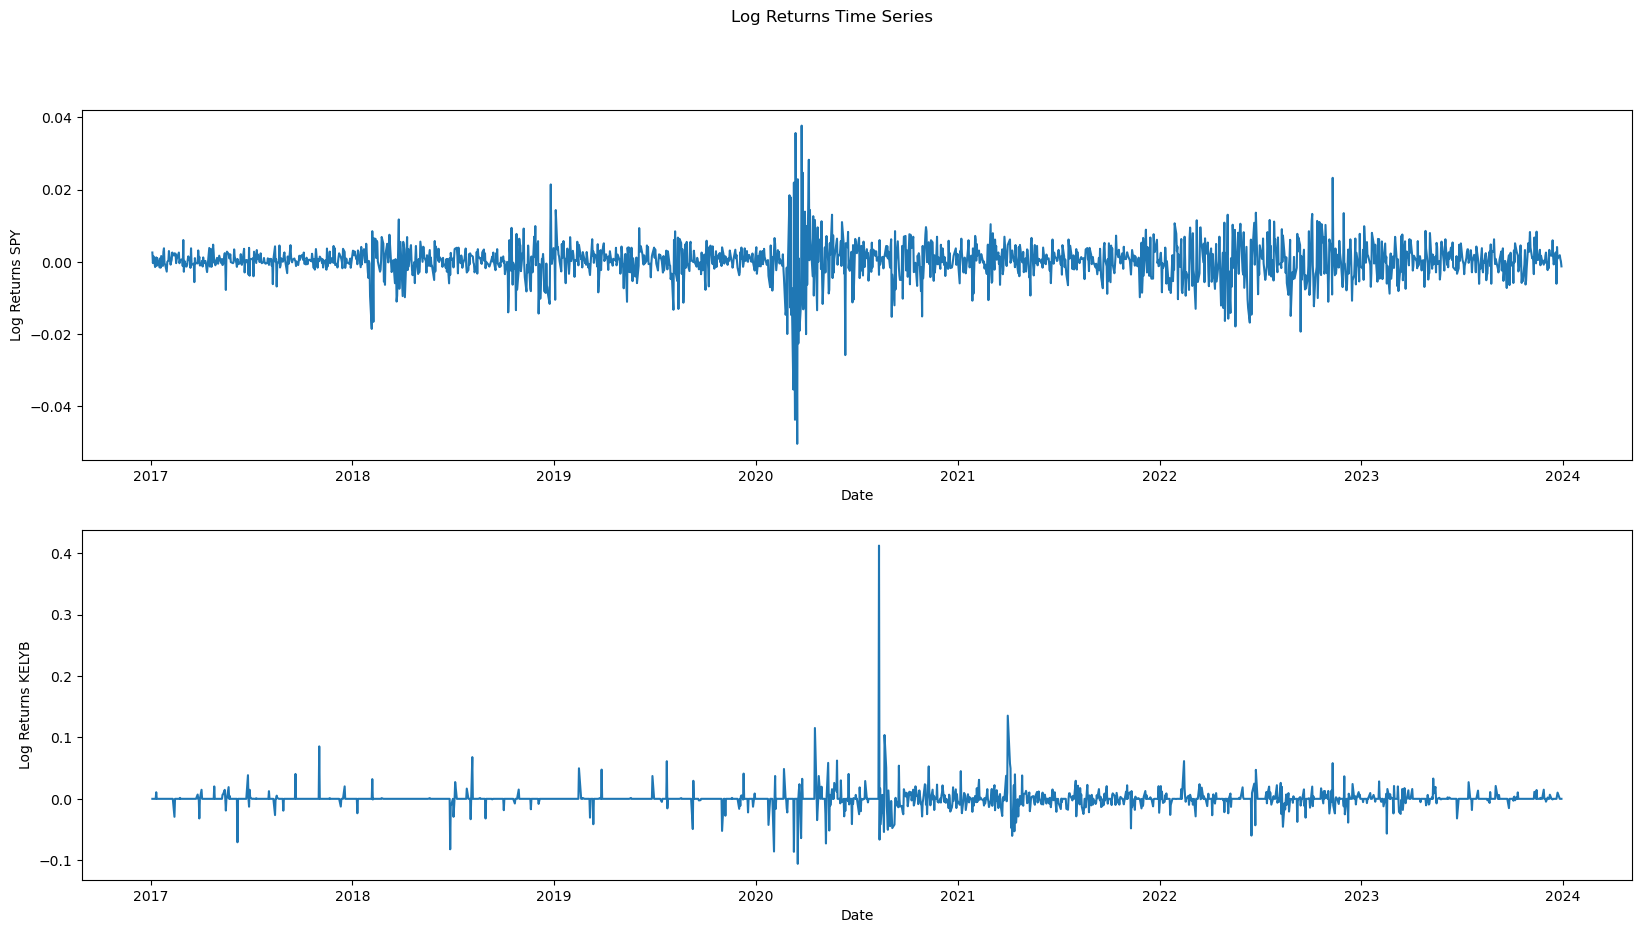

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x='Date', y=f'Log Returns {LIQUID_INDEX_TICKER}', data=final_df, ax=ax[0])
sns.lineplot(x='Date', y=f'Log Returns {ILLIQUID_TICKER}', data=final_df, ax=ax[1])
fig.suptitle('Log Returns Time Series')

/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_41457/1486942583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] = np.log10(vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] + 1)
/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_41457/1486942583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_return[f'Volume_{ILLIQUID_TICKER}'] = np.log10(vol_return[f'Volume_{ILLIQUID_TICKER}'] + 1)


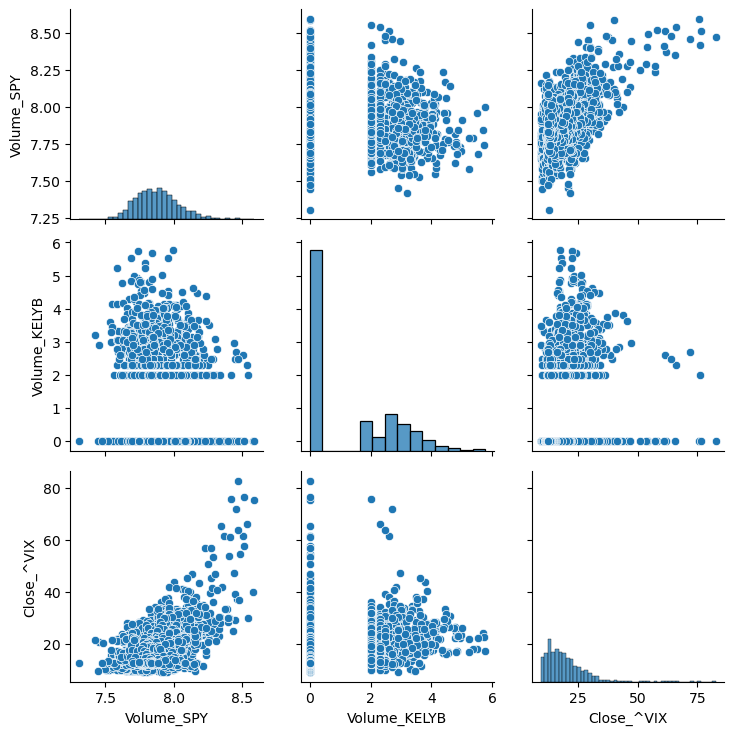

In [8]:
vol_return = final_df[[f'Volume_{LIQUID_INDEX_TICKER}', f'Volume_{ILLIQUID_TICKER}', f'Close_{VOLATILITY_TRACKER}']]
vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] = np.log10(vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] + 1)
vol_return[f'Volume_{ILLIQUID_TICKER}'] = np.log10(vol_return[f'Volume_{ILLIQUID_TICKER}'] + 1)
g = sns.PairGrid(data=vol_return)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_41457/2400717402.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] = np.log10(illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] + 1)


<Figure size 2000x2000 with 0 Axes>

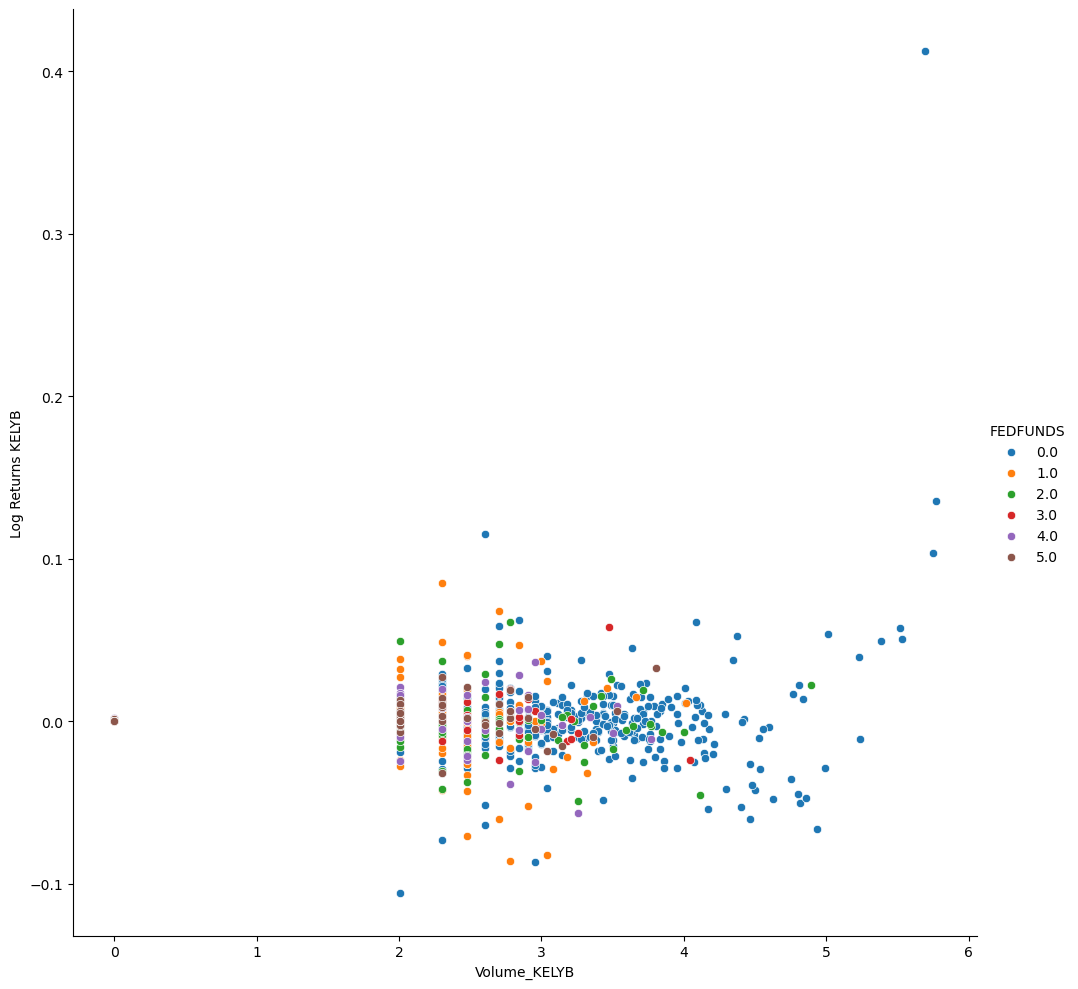

In [9]:
illiquid_vol = final_df[[f'Volume_{ILLIQUID_TICKER}', 'FEDFUNDS', f'Log Returns {ILLIQUID_TICKER}']]
illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] = np.log10(illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] + 1)
plt.figure(figsize=(20, 20))
g = sns.FacetGrid(data=illiquid_vol, hue='FEDFUNDS', height=10, aspect=1)
g.map(sns.scatterplot, f'Volume_{ILLIQUID_TICKER}', f'Log Returns {ILLIQUID_TICKER}')
g.add_legend()

/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_41457/398307554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] = np.log10(illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] + 1)


<Figure size 2000x2000 with 0 Axes>

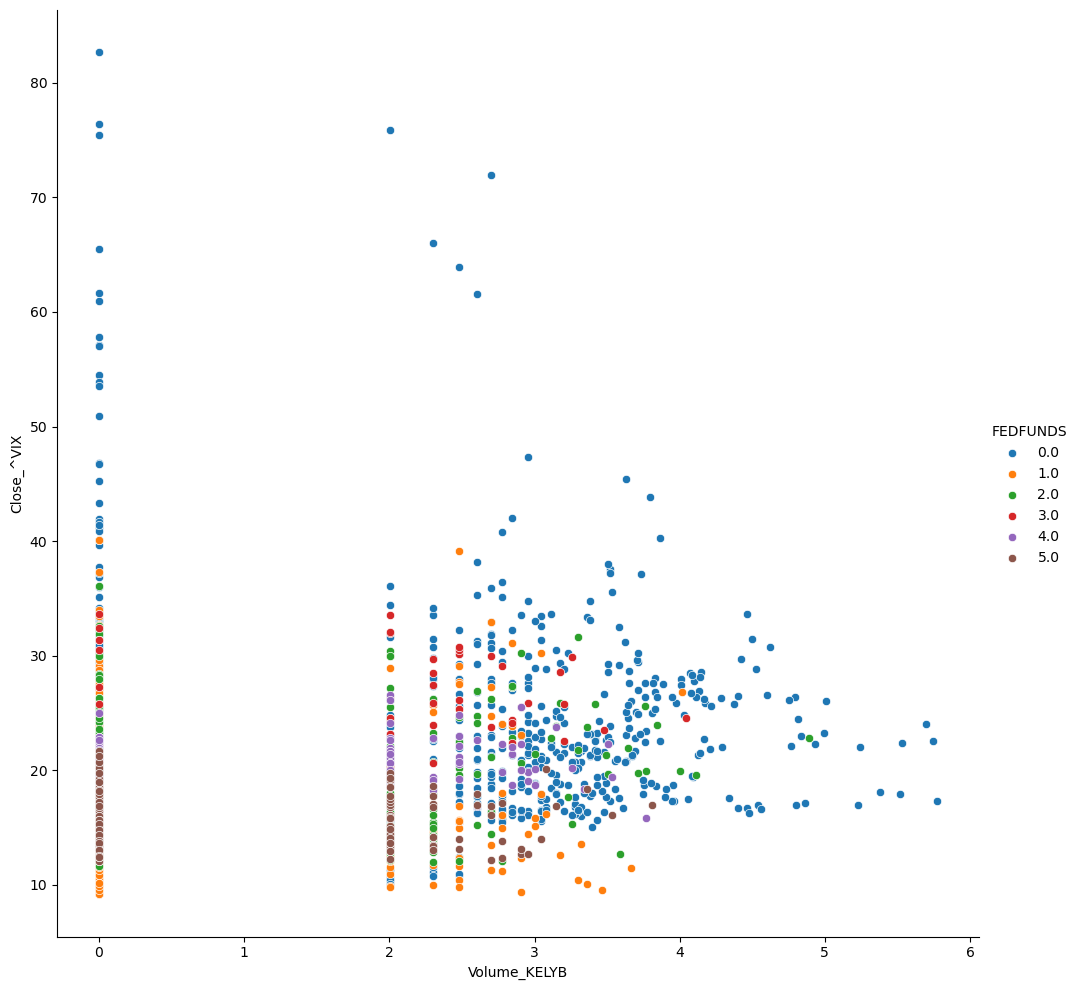

In [10]:
illiquid_vol = final_df[[f'Volume_{ILLIQUID_TICKER}', 'FEDFUNDS', f'Close_{VOLATILITY_TRACKER}']]
illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] = np.log10(illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] + 1)
plt.figure(figsize=(20, 20))
g = sns.FacetGrid(data=illiquid_vol, hue='FEDFUNDS', height=10, aspect=1)
g.map(sns.scatterplot, f'Volume_{ILLIQUID_TICKER}', f'Close_{VOLATILITY_TRACKER}')
g.add_legend()

<Figure size 2000x2000 with 0 Axes>

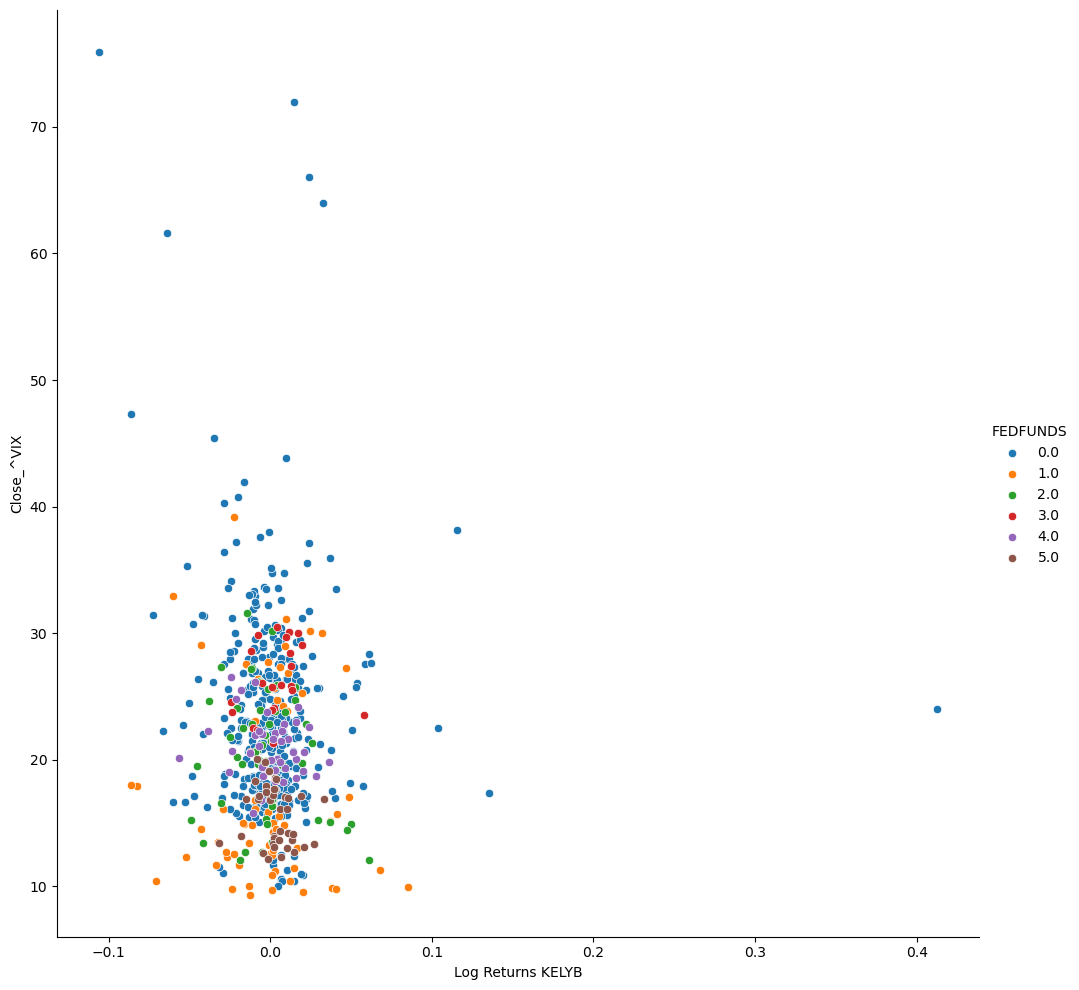

In [20]:
illiquid_ret = final_df[[f'Log Returns {ILLIQUID_TICKER}', 'FEDFUNDS', f'Close_{VOLATILITY_TRACKER}']]
plt.figure(figsize=(20, 20))
g = sns.FacetGrid(data=illiquid_ret[illiquid_ret['Log Returns KELYB'] != 0].dropna(), hue='FEDFUNDS', height=10, aspect=1)
g.map(sns.scatterplot, f'Log Returns {ILLIQUID_TICKER}', f'Close_{VOLATILITY_TRACKER}')
g.add_legend()